# Social Media Monitor

In this project i'll implement a social media monitor that tracks topics or trends from social media or blogs. This project can help businesses or individuals stay up-to-date with the latest developments and discussions related to their areas of interest.

To implement this project, I'll follow these steps:

- **1. Data Collection:** Gather data from various sources like news websites, blogs, and social media using APIs or web scraping techniques or RSS feed. In this case I'll use the 20newsgroups dataset from Sklearn that comprises around 18000 newsgroups posts on 20 topics.
- **2. Text Preprocessing:** Clean and normalize the text data using stopword removal, stemming and lemmatization.
- **3. Topic Modeling:** Employ topic modeling techniques like Latent Dirichlet Allocation (LDA) to identify the main topics or themes present in the collected data. This will help filter relevant content based on the topics of interest.
- **4. Sentiment Analysis:** Determine the sentiment of the content (positive, negative, or neutral) using a rule-based approach like VADER sentiment analyzer.
- **5. Summarization:** Generate summaries of the relevant content using extractive summarization based on word frequencies, so that users can quickly grasp the main points without reading the entire text.
- **6. Visualization and Reporting:** Visualize the results in an intuitive dashboard or report format, showing the distribution of topics, sentiment scores, and summaries of the relevant content.

# **0. Import libraries:**


In [1]:
"""
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install nltk
%pip install gensim
%pip install pyLDAvis
%pip install vaderSentiment
%pip install wordcloud
%pip install matplotlib
"""

'\n%pip install numpy\n%pip install pandas\n%pip install scikit-learn\n%pip install nltk\n%pip install gensim\n%pip install pyLDAvis\n%pip install vaderSentiment\n%pip install wordcloud\n%pip install matplotlib\n'

In [2]:
import numpy as np
np.random.seed(42)

from pprint import pprint

# --------------- Dataset ------------- #
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

# --------------- Pre-Processing -------- #
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer

# --------------- LDA Model ---------- #
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
# --------------- Sentiment Analysis --------- #
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# --------------- 

# --------------- Visualize and Report ----------- #
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\robyd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\robyd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\robyd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **1. Data Collection:**
Now, let's load the 20newsgroup dataset and focus on the 5 categories for training:
http://qwone.com/~jason/20Newsgroups/

In [3]:
# Verify train dataset is balanced
baseball_train = fetch_20newsgroups(subset='train', categories=['rec.sport.baseball'], remove=('headers', 'footers', 'quotes'))
print("Baseball dataset size: ", len(baseball_train.data))

hardware_train = fetch_20newsgroups(subset='train', categories=['comp.sys.ibm.pc.hardware'], remove=('headers', 'footers', 'quotes'))
print("Hardware dataset size: ", len(hardware_train.data))

med_train = fetch_20newsgroups(subset='train', categories=['sci.med'], remove=('headers', 'footers', 'quotes'))
print("Med dataset size: ", len(med_train.data))

space_train = fetch_20newsgroups(subset='train', categories=['sci.space'], remove=('headers', 'footers', 'quotes'))
print("Space dataset size: ", len(space_train.data))

guns_train = fetch_20newsgroups(subset='train', categories=['talk.politics.guns'], remove=('headers', 'footers', 'quotes'))
print("Guns dataset size: ", len(guns_train.data))

crypt_train = fetch_20newsgroups(subset='train', categories=['sci.crypt'], remove=('headers', 'footers', 'quotes'))
print("Crypt dataset size: ", len(crypt_train.data))

Baseball dataset size:  597
Hardware dataset size:  590
Med dataset size:  594
Space dataset size:  593
Guns dataset size:  546
Crypt dataset size:  595


In [4]:
# Create train dataset with selected categories
train_categories = ['comp.sys.ibm.pc.hardware', 'rec.sport.baseball', 'sci.med', 'sci.space', 'talk.politics.guns']
newsgroups_train = fetch_20newsgroups(subset='train', categories=train_categories, remove=('headers', 'footers', 'quotes'))
#newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

print(newsgroups_train.target_names)
print(newsgroups_train.target[:30])

['comp.sys.ibm.pc.hardware', 'rec.sport.baseball', 'sci.med', 'sci.space', 'talk.politics.guns']
[1 4 2 3 3 1 4 4 2 1 0 3 4 1 2 3 0 0 3 1 3 2 0 0 4 0 2 4 3 3]


For the test set, I will create a custom dataset with 70% rec.autos and 30% sci.space documents:

In [5]:
# Create test dataset with 100 samples: 70% guns and 30% space
n_test_docs = 100
n_guns_docs = int(n_test_docs * 0.7)
n_space_docs = n_test_docs - n_guns_docs

# Fetch data for each category
guns_test = fetch_20newsgroups(subset='test', categories=['talk.politics.guns'], remove=('headers', 'footers', 'quotes'))
space_test = fetch_20newsgroups(subset='test', categories=['sci.space'], remove=('headers', 'footers', 'quotes'))

# Randomly select the desired number of documents from each category
guns_indices = np.random.choice(len(guns_test.data), n_guns_docs, replace=False)
space_indices = np.random.choice(len(space_test.data), n_space_docs, replace=False)

# Create the test dataset
test_data = [guns_test.data[i] for i in guns_indices] + [space_test.data[i] for i in space_indices]
test_target = np.concatenate((guns_test.target[guns_indices], space_test.target[space_indices]))

# Create the newsgroups_test dataset
newsgroups_test = {
    'data': test_data,
    'target': test_target,
    'target_names': ['talk.politics.guns', 'sci.space']
}

print("Newsgroups test dataset size: ", len(newsgroups_test['data']))

Newsgroups test dataset size:  100


In [6]:
print(test_data[0])

In the wake of the Waco denouement, I had email discussions with
people from this group.  In particular, we discussed how cults
operate, why the FBI might be motivated to black out news or behave
the way it did, and what kinds of problems are involved in dealing
with cults and similar organizations.

I include an edited account of what I wrote.  The identity of my
correspondents have (I hope) been erased.  The editing process makes
the text choppy - sorry about that.  I've tried to retain the
information content.

Ellipses (...) indicate where text was removed.  A few of the comments
in parentheses are new, intended to make it easier for outsiders to
understand.

These notes are preliminary - feel free to criticize.

Cheers(?),
Oded

------------------------ (begin included text) -----------------------

I took a course called the MADNESS OF CROWDS, ...  The course included
cults and briefly mentioned/analyzed Jonestown.  (Did some external
reading too).

William Adorno ... edited a se

In [7]:
print("Train dataset size: ", len(newsgroups_train.data))
print("Train topics are:\n",newsgroups_train.target_names)

print("\nTest dataset size: ", len(test_data))

Train dataset size:  2920
Train topics are:
 ['comp.sys.ibm.pc.hardware', 'rec.sport.baseball', 'sci.med', 'sci.space', 'talk.politics.guns']

Test dataset size:  100


# **2. Text Preprocessing:** 
Clean and normalize the text data using tokenization, stopword removal, and stemming/lemmatization. I'll use the `nltk` library for these tasks.

In [8]:
def preprocess_text(data):
    # Remove punctuation and stopwords
    stop_words = set(stopwords.words('english'))

    def tokenize(text):
        return [word for word in word_tokenize(text.lower()) if word.isalnum() and word not in stop_words]

    def lemmatize(text):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in text]

    # Tokenization
    tokenized_data = [tokenize(text) for text in data]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_data = [[stemmer.stem(token) for token in text] for text in tokenized_data]

    # Lemmatize
    lemmatized_data = [lemmatize(text) for text in tokenized_data]

    return stemmed_data, lemmatized_data

In [9]:
stemmed_train_data, lemmatized_train_data = preprocess_text(newsgroups_train.data)

In [10]:
print(stemmed_train_data[:1])

[['brook', 'robinson', 'defens', 'liabil', 'ted', 'william', 'weak', 'hitter', 'even', 'great', 'player', 'declin', 'age']]


In [11]:
print(lemmatized_train_data[:1])

[['brook', 'robinson', 'defensive', 'liability', 'ted', 'williams', 'weak', 'hitter', 'even', 'great', 'player', 'decline', 'age']]


In [12]:
stemmed_test_data, lemmatized_test_data = preprocess_text(test_data)
print(lemmatized_test_data[:1])

[['wake', 'waco', 'denouement', 'email', 'discussion', 'people', 'group', 'particular', 'discussed', 'cult', 'operate', 'fbi', 'might', 'motivated', 'black', 'news', 'behave', 'way', 'kind', 'problem', 'involved', 'dealing', 'cult', 'similar', 'organization', 'include', 'edited', 'account', 'wrote', 'identity', 'correspondent', 'hope', 'erased', 'editing', 'process', 'make', 'text', 'choppy', 'sorry', 'tried', 'retain', 'information', 'content', 'ellipsis', 'indicate', 'text', 'removed', 'comment', 'parenthesis', 'new', 'intended', 'make', 'easier', 'outsider', 'understand', 'note', 'preliminary', 'feel', 'free', 'criticize', 'cheer', 'oded', 'begin', 'included', 'text', 'took', 'course', 'called', 'madness', 'crowd', 'course', 'included', 'cult', 'briefly', 'jonestown', 'external', 'reading', 'william', 'adorno', 'edited', 'series', 'book', 'psychology', 'evil', 'mass', 'movement', 'starting', 'authoritarian', 'personality', 'university', 'chicago', 'press', '1948', 'attempt', 'figure

# **3. Topic Modeling:** 
Apply Latent Dirichlet Allocation (LDA) to identify the main topics in the collected data. In this part I'll use a scratch implementation and compare it with `gensim` library version. To evaluate both models on the testing set I compute the coherence scores.

Remember, for topic modeling, you can train your model on any similar corpus of text documents. It doesn't necessarily have to contain the same topics as your unseen documents but having some overlap would likely improve performance. For example, if you're looking to categorize social media posts from a specific platform or about a specific subject, you would ideally use a training set gathered from the same or similar platform/subject.

However, if you want to train an LDA model on the specific topics you mentioned, you would need a dataset that contains a substantial number of documents related to these topics.


## Latent Dirichlet Model 

Latent Dirichlet Allocation (LDA) is a generative probabilistic model used in topic modeling. It is a statistical model that allows us to discover latent topics within a collection of documents. LDA assumes that each document in the collection is a mixture of various topics, and each topic is a distribution over words.

It's an unsupervised learning method, meaning that it generates a probabilistic model to identify groups of topics without the need for known class labels. It uses only the distribution of words to mathematically model topic.

Here's a step-by-step explanation of how LDA works:

1. **Initialization**: Choose the number of topics K and randomly assign each word in each document to one of the K topics.

2. **Iteration**:
   - For each document d:
     - For each word w in document d:
       - Calculate two probabilities:
         - P(topic t | document d): Proportion of words in document d that are currently assigned to topic t.
         - P(word w | topic t): Proportion of assignments to topic t over all documents that come from word w.
       - Reassign word w to a new topic based on the probabilities calculated above.
   
   - Repeat the above step for a fixed number of iterations or until convergence.

3. **Output**: After the iterations, LDA provides two main outputs:
   - The distribution of topics in each document.
   - The distribution of words in each topic.

These distributions can be used to interpret the topics and analyze the relationships between documents and topics.

LDA assumes that documents are generated in the following way:
- Choose the number of words in the document from a Poisson distribution.
- Choose a topic mixture for the document from a Dirichlet distribution.
- For each word in the document:
  - Choose a topic from the topic mixture.
  - Choose a word from the topic's word distribution.

LDA is widely used in natural language processing and text mining tasks, such as document clustering, document classification, and information retrieval. It helps uncover the underlying themes or topics in a collection of documents, making it easier to analyze and organize large amounts of textual data[1].

Please note that the search results provided additional papers and applications related to LDA, which you can explore for more specific information and use cases.

Citations:
[1] https://www.semanticscholar.org/paper/b98a4076b48552691bb99290106a378e483cdfca
[2] https://www.semanticscholar.org/paper/03ba268430128916e195e8d1a88c761f3c9d7578
[3] https://arxiv.org/abs/1309.3421
[4] https://www.semanticscholar.org/paper/c80db2cd1b127ec86060ad018c04cd0c48075ae3
[5] https://www.semanticscholar.org/paper/1713b2a9291d76c02feb49376422d800d5e44888
[6] https://www.semanticscholar.org/paper/59c902e7797889bad1f731205a409ade2913199a


The documents can come from any domain as long as they contain text. For example, they could be customer reviews, news articles, research papers, social media posts, etc. The words in the documents are collected into n-grams (a contiguous sequence of n items from a given sample of text or speech) and used to create a dictionary. This dictionary is then used to train the LDA model. 

It's important to note that the text in the documents should be preprocessed before being used for training the LDA model. This preprocessing can include removing stop words (commonly used words such as 'the', 'a', 'an', 'in'), lowercasing all the words, and lemmatizing the words (reducing inflectional forms and sometimes derivationally related forms of a word to a common base form)

When configuring the LDA model, some parameters that can be set include the rho parameter (a prior probability for the sparsity of topic distributions), the alpha parameter (a prior probability for the sparsity of per-document topic weights), the estimated number of documents, the size of the batch, the initial value of iteration used in learning update schedule, the power applied to the iteration during updates, and the number of passes over the data


As a result of the training, each document will be represented as a combination of topics, and each topic will be represented as a distribution over words. This can be used to classify new documents, identify related terms, and create recommendations.

![LDA](https://www.researchgate.net/profile/Diego-Buenano-Fernandez/publication/339368709/figure/fig1/AS:860489982689280@1582168207260/Schematic-of-LDA-algorithm.png)

## Gensim version

In [13]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(lemmatized_train_data)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(text) for text in lemmatized_train_data]

In [14]:
# human-readable format of corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('age', 1),
  ('brook', 1),
  ('decline', 1),
  ('defensive', 1),
  ('even', 1),
  ('great', 1),
  ('hitter', 1),
  ('liability', 1),
  ('player', 1),
  ('robinson', 1),
  ('ted', 1),
  ('weak', 1),
  ('williams', 1)]]

**Building the Topic Model**

Let's now build the topic model. We'll define 5 topics to start with. The hyperparameter alpha affects sparsity of the document-topic (theta) distributions, whose default value is 1. Similarly, the hyperparameter eta can also be specified, which affects the topic-word distribution's sparsity.

https://www.kaggle.com/code/datajameson/topic-modelling-nlp-amazon-reviews-bbc-news

In [15]:
num_topics = 5

# Train the LDA model using the processed training data
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10, alpha='auto', per_word_topics=True)

In [16]:
# Mapping between topic number and category name
topic_category_mapping = {
    0: 'Guns',
    1: 'Baseball',
    2: 'Med',
    3: 'Hardware',
    4: 'Space'
}

In [17]:
# Print topics and associated category names
for topic_num, topic in lda_model.show_topics(num_topics=num_topics, formatted=False):
    topic_words = [word for word, _ in topic]
    category_name = topic_category_mapping.get(topic_num, f'Unknown Category {topic_num}')
    print(f"Topic {topic_num} ({category_name}) | Words: {topic_words}\n")

Topic 0 (Guns) | Words: ['would', 'one', 'gun', 'like', 'get', 'know', 'time', 'people', 'problem', 'thing']

Topic 1 (Baseball) | Words: ['would', 'year', 'one', 'game', 'think', 'get', 'good', 'last', 'team', 'well']

Topic 2 (Med) | Words: ['center', 'research', 'medical', 'space', 'health', '1993', 'disease', 'cancer', 'information', 'use']

Topic 3 (Hardware) | Words: ['drive', '1', '0', '2', 'card', 'controller', '3', 'scsi', 'disk', '4']

Topic 4 (Space) | Words: ['space', 'launch', 'satellite', 'system', 'data', 'nasa', 'also', 'orbit', 'program', 'year']



In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.120655  0.063418       1        1  39.278800
1      0.118096  0.131451       2        1  22.814819
4     -0.003482 -0.116042       3        1  14.701494
2      0.028702 -0.151663       4        1  14.020247
3     -0.263971  0.072836       5        1   9.184640, topic_info=         Term        Freq       Total Category  logprob  loglift
610     drive  799.000000  799.000000  Default  30.0000  30.0000
145     space  729.000000  729.000000  Default  29.0000  29.0000
854         1  718.000000  718.000000  Default  28.0000  28.0000
3481        0  339.000000  339.000000  Default  27.0000  27.0000
1064        2  623.000000  623.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
130      hard  137.766654  289.452535   Topic5  -5.1934   1.6452
568    system  168.915315  642.109621   Topic5  -4.9896   1.0523
884         6  108.814337  283.840701   Topic5  -5.4293   1.4289
109   support   98.852122  314.153760   Topic5  -5.5253   1.2314
371        pc   82.389675  147.508924   Topic5  -5.7075   1.8052

[395 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
3481       2  0.032367      0
3481       5  0.965118      0
12071      5  0.989103     02
12072      5  0.947191     03
15894      5  0.980904     04
...      ...       ...    ...
117        5  0.004993  would
170        1  0.261291   year
170        2  0.504303   year
170        3  0.137635   year
170        4  0.095699   year

[836 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 4])

Let's now evaluate the model using coherence score

In [19]:
# Calculate the coherence score to evaluate the model
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_train_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)

Coherence Score: 0.5851297304199818


In [31]:
def get_topic_distribution(lda_model, dictionary, document):
    # Preprocess the document
    _, preprocessed_document = preprocess_text([document])
    # Convert the document into BoW format
    bow_document = dictionary.doc2bow(preprocessed_document[0]) # Here we are assuming that preprocessed_document is a list of lists
    
    # Get the topic distribution
    topic_distribution = lda_model.get_document_topics(bow_document, minimum_probability=0.2)
    return topic_distribution

In [32]:
test_topic_distributions = [get_topic_distribution(lda_model, dictionary, text) for text in test_data]

# Display the topic distribution for all test documents
for i, topic_dist in enumerate(test_topic_distributions):
    # Sort the topic distribution by probability in descending order
    sorted_topic_dist = sorted(topic_dist, key=lambda x: -x[1])
    # Create a list to store the formatted topics
    formatted_topics = []

    # Format and store each topic
    for topic_id, probability in sorted_topic_dist:
        # Associate label to the topic
        category_name = topic_category_mapping.get(topic_id, f'Unknown Category {topic_id}')

        formatted_topic = f"[{topic_id}] {category_name} {probability}"
        formatted_topics.append(formatted_topic)

    # Join the formatted topics into a string
    formatted_topics_str = " - ".join(formatted_topics)

    print(f"Document {i + 1} topics : {formatted_topics_str}")

Document 1 topics : [0] Guns 0.5046497583389282 - [1] Baseball 0.42727285623550415
Document 2 topics : [0] Guns 0.900154173374176
Document 3 topics : [1] Baseball 0.5469791293144226 - [0] Guns 0.4511624574661255
Document 4 topics : [0] Guns 0.9396575689315796
Document 5 topics : [1] Baseball 0.47918134927749634 - [0] Guns 0.34325262904167175
Document 6 topics : [0] Guns 0.6676731109619141 - [1] Baseball 0.2957719564437866
Document 7 topics : [0] Guns 0.5982745289802551 - [1] Baseball 0.39682143926620483
Document 8 topics : [0] Guns 0.7640882730484009
Document 9 topics : [0] Guns 0.848506510257721
Document 10 topics : [0] Guns 0.7612853646278381
Document 11 topics : [0] Guns 0.7150983214378357
Document 12 topics : [0] Guns 0.8956743478775024
Document 13 topics : [0] Guns 0.728699266910553
Document 14 topics : [1] Baseball 0.6463239192962646 - [0] Guns 0.352009117603302
Document 15 topics : [1] Baseball 0.5023956298828125 - [0] Guns 0.4948951303958893
Document 16 topics : [0] Guns 0.9098

## Scratch version

In [ ]:
import numpy as np

def compute_coherence_score(lda_model, texts, dictionary):
    topics = lda_model.get_topics()
    coherence_score = 0.0
    num_topics = len(topics)
    num_texts = len(texts)

    for i in range(num_topics):
        topic = topics[i]
        topic_words = [dictionary[word_id] for word_id in topic]
        topic_word_set = set(topic_words)
        topic_word_freq = {word: topic_words.count(word) for word in topic_word_set}

        for j in range(num_texts):
            text = texts[j]
            text_word_set = set(text)
            common_words = topic_word_set.intersection(text_word_set)
            common_word_freq = {word: text.count(word) for word in common_words}

            coherence_score += np.log(sum(common_word_freq.values()) + 1) - np.log(len(text))

    coherence_score /= num_topics * num_texts

    return coherence_score


In [ ]:
coherence_score = compute_coherence_score(lda_model, processed_train_data, dictionary)
print('Coherence Score:', coherence_score)

# **4. Sentiment Analysis:**
Determine the sentiment of the content using the VADER sentiment analyzer from the `vaderSentiment`library.
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a pre-trained sentiment analysis tool specifically designed for social media texts and doesn't require preprocessing like tokenization, stemming, or lemmatization

In [33]:
# Function to analyze sentiment using VADER
def get_sentiment(text):
     # Initialize VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores

In [34]:
test_sentiments = [get_sentiment(text) for text in test_data]

In [35]:
# Display the sentiment scores for the first 10 test documents
scores_list = []
for i, sentiment in enumerate(test_sentiments):
    scores_list.append(sentiment['compound'])
    print(f"Document {i + 1}: {sentiment}")
    
print(f"\nAverage sentiment: {np.mean(scores_list)}")

Document 1: {'neg': 0.155, 'neu': 0.754, 'pos': 0.091, 'compound': -0.9983}
Document 2: {'neg': 0.228, 'neu': 0.772, 'pos': 0.0, 'compound': -0.9344}
Document 3: {'neg': 0.089, 'neu': 0.872, 'pos': 0.039, 'compound': -0.9012}
Document 4: {'neg': 0.185, 'neu': 0.683, 'pos': 0.132, 'compound': -0.782}
Document 5: {'neg': 0.0, 'neu': 0.966, 'pos': 0.034, 'compound': 0.128}
Document 6: {'neg': 0.047, 'neu': 0.925, 'pos': 0.028, 'compound': -0.6478}
Document 7: {'neg': 0.269, 'neu': 0.634, 'pos': 0.097, 'compound': -0.9509}
Document 8: {'neg': 0.013, 'neu': 0.964, 'pos': 0.023, 'compound': 0.2663}
Document 9: {'neg': 0.082, 'neu': 0.864, 'pos': 0.054, 'compound': -0.5255}
Document 10: {'neg': 0.113, 'neu': 0.752, 'pos': 0.135, 'compound': 0.7646}
Document 11: {'neg': 0.034, 'neu': 0.849, 'pos': 0.118, 'compound': 0.9995}
Document 12: {'neg': 0.105, 'neu': 0.858, 'pos': 0.037, 'compound': -0.5574}
Document 13: {'neg': 0.128, 'neu': 0.782, 'pos': 0.09, 'compound': -0.5585}
Document 14: {'neg'

# **5. Summarization:**
Generate summaries of the relevant content using extractive summarization based on word frequency. For this, I'll follow these steps:
- 1. Split the text into sentences.
- 2. Tokenize the sentences.
- 3. Calculate the frequency of each word in the text.
- 4. Assign a score to each sentence based on the frequency of the words in the sentence.
- 5. Select the top N sentences with the highest scores as the summary.

This is a simple implementation of extractive summarization without using any libraries. Note that this approach does not consider the semantic meaning of words or the coherence of the summary. More advanced techniques, such as using word embeddings or graph-based methods, can improve the quality of the summary.

In [36]:
def extractive_summarization(text, n_sentences=3):
    # Split the text into sentences
    sentences = text.strip().split('.')

    # Tokenize and preprocess the text
    word_freq = {}
    for sentence in sentences:
        stemmed_tokens, _ = preprocess_text([sentence])
        # Flatten the stemmed_tokens list
        stemmed_tokens = [token for sublist in stemmed_tokens for token in sublist]
        for token in stemmed_tokens:
            if token not in word_freq:
                word_freq[token] = 1
            else:
                word_freq[token] += 1

    # Calculate the score for each sentence
    sentence_scores = {}
    for sentence in sentences:
        stemmed_tokens, _ = preprocess_text([sentence])
        # Flatten the stemmed_tokens list
        stemmed_tokens = [token for sublist in stemmed_tokens for token in sublist]
        for token in stemmed_tokens:
            if token in word_freq:
                if sentence not in sentence_scores:
                    sentence_scores[sentence] = word_freq[token]
                else:
                    sentence_scores[sentence] += word_freq[token]

    # Select the top N sentences with the highest scores
    summary_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)[:n_sentences]
    summary = '. '.join(summary_sentences)

    return summary

In [37]:
summaries = [extractive_summarization(text, n_sentences=1) for text in test_data]

# Print summary for every document in the test set
for i, summary in enumerate(summaries):
    print(f"Summary {i + 1}: {summary}")

Summary 1:   The "logic" of saying that no matter how bad the gummint is, it
wouldn't kill the kids, was shouted down as blasphemy, and the people
who brought it up were threatened with ostracism by people who by
THEIR OWN AVOWAL would be dead within the hour
Summary 2: "  How the hell do you use an armor-piercing rifle?  Run
up to a tank and try to stab it?

Once again, ignorance prevails amongst the media 
Summary 3:   

I am hard pressed to see any real difference between the claimed power Koresh  
held over the BDs, and the demonstrated power the government holds over those  
rapid apologists
Summary 4: I don't know this specific ratio, but I do have an earlier post that says
a gun is 33 times more likely to defend someone (including the times where
the gun isn't fired, just scares the perpetrator away) than it is to kill
someone
Summary 5: The Associated Press had an article on Monday March 1, I believe,
which quoted witnesses as describing BATF agents throwing grenades prior
to a

# **6. Visualization and Reporting:**
Visualize the results in an intuitive dashboard or report format, showing the distribution of topics, sentiment scores, and summaries of the relevant content. 

In [38]:
# Merge all the texts in the test set
merged_test_text = ' '.join(test_data)

## Main topic

In [39]:
# Get the topic distribution for the merged text
merged_text_topic_distribution = get_topic_distribution(lda_model, dictionary, merged_test_text)

print(f"\nMain topics distribution:")

# Display the topic distribution for all test documents
for i, topic_dist in enumerate(merged_text_topic_distribution):
    sorted_topic_dist = sorted([topic_dist], key=lambda x: -x[1])
    formatted_topics = []
    for topic_id, probability in sorted_topic_dist:
        topic_name = topic_category_mapping.get(topic_id, f'Unknown Category {topic_id}')
        formatted_topic = f"[{topic_id}] {topic_name} -> {probability}"
        formatted_topics.append(formatted_topic)
    formatted_topics_str = " - ".join(formatted_topics)
    print(f"{formatted_topics_str}")

# Identify the main topic based on the highest average topic distribution
main_topic = max(merged_text_topic_distribution, key=lambda x: x[1])[0]
topic_name = topic_category_mapping.get(main_topic, f'Unknown Category {topic_num}')

# Display the main topic keywords
main_topic_keywords = lda_model.show_topic(main_topic)
print(f"\nMain {topic_name} keywords:\n{main_topic_keywords}")



Main topics distribution:
[0] Guns -> 0.6212282776832581
[1] Baseball -> 0.253171443939209

Main Guns keywords:
[('would', 0.009276755), ('one', 0.008098404), ('gun', 0.0074029597), ('like', 0.005558507), ('get', 0.005383595), ('know', 0.005368865), ('time', 0.005036473), ('people', 0.0050030183), ('problem', 0.004014722), ('thing', 0.0036522488)]


## Average sentiment

In [40]:
merged_text_sentiment = get_sentiment(merged_test_text)

print(f"Global Text Sentiment: {merged_text_sentiment}")

Global Text Sentiment: {'neg': 0.104, 'neu': 0.796, 'pos': 0.1, 'compound': -0.9996}


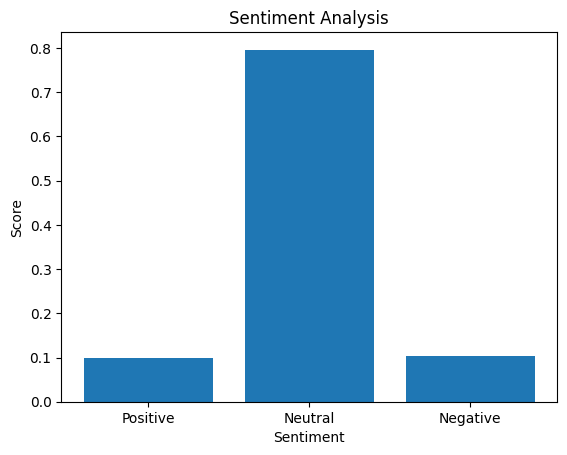

In [41]:
# Function to visualize sentiment scores
def visualize_sentiment(sentiment_scores):
    labels = ['Positive', 'Neutral', 'Negative']
    values = [sentiment_scores['pos'], sentiment_scores['neu'], sentiment_scores['neg']]

    plt.bar(labels, values)
    plt.xlabel('Sentiment')
    plt.ylabel('Score')
    plt.title('Sentiment Analysis')
    plt.show()
    
visualize_sentiment(merged_text_sentiment)

## Summary

In [42]:
summary = extractive_summarization(merged_test_text, n_sentences=3)
print(summary)

"

[Schulman:] "(2) Is 'the right of the people to keep and bear arms' granted
by the words of the Second Amendment, or does the Second Amendment assume a
preexisting right of the people to keep and bear arms, and merely state
that such right 'shall not be infringed'?"

[Copperud:] "(2) The right is not granted by the amendment; its existence
is assumed. 

"In reply to your numbered questions:

[Schulman:] "(1) Can the sentence be interpreted to grant the right to keep
and bear arms solely to 'a well-regulated militia'?"

[Copperud:] "(1) The sentence does not restrict the right to keep and bear
arms, nor does it state or imply possession of the right elsewhere or by
others than the people; it simply makes a positive statement with respect
to a right of the people.  Sternlight:  The RIGHT described is a "right of the people
to keep and bear arms;" not a "right of the people to form a militia," a
"right of a militia to keep and bear arms," or a "right of well-regulated
people to keep an

## Word distribution

In [43]:
# Function to generate a word cloud
def generate_wordcloud(texts):
    all_text = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=5, max_words=100).generate(all_text)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Texts')
    plt.show()

E:\Programmi\Anaconda\envs\unige\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


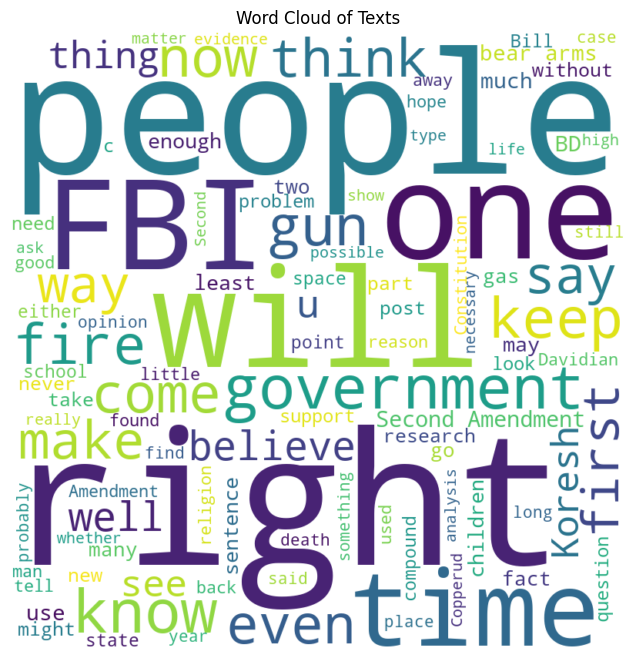

In [44]:
# Generate word cloud
generate_wordcloud([merged_test_text])